In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from tqdm import tqdm
import itertools
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from networkx.algorithms import bipartite
from sklearn.preprocessing import normalize
import ast
from scipy import sparse

text_font = 15
mpl.rcParams.update({'font.size': text_font, 'font.style': 'normal', 'font.family':'sans-serif'})

dat_path = os.getcwd() + '/data/'
fig_path = os.getcwd() + '/figures/'

### Structure of the Notebook

#### Imports and Configuration
- Import necessary libraries such as `numpy`, `networkx`, `matplotlib`, `pandas`, `os`, etc.
- Set up matplotlib configurations for font size and style.
- Define paths for data and figures.

#### Functions

##### `noise_corrected` and `disparity_filter`
- Function to apply noise-corrected and disparity filter backboning technique on a given network.

##### `weighted` and `newman` and `ycn` and `probs` and `unweighted`
- Function to create a weighted bipartite graph and rank links using different methods.

##### `create_bipartite_graph`
- Function to create a bipartite graph from tool affinity data.

##### `fig_S10_A`
- Function to generate and save network diagrams illustrating the original network and its backboned versions using NC and DF techniques.

##### `fig_S10_BCDE`
- Function to generate and save plots comparing the original network and its backboned versions using NC and DF techniques.

##### `fig_S11_BCD`
- Function to generate and save a heatmap comparing different link projection methods using Spearman correlation.


In [2]:
def noise_corrected(table, undirected = False, return_self_loops = False, calculate_p_value = False, threshold = None):

    table = table.copy()

    src_sum = table.groupby(by = "src").sum()[["nij"]]
    table = table.merge(src_sum, left_on = "src", right_index = True, suffixes = ("", "_src_sum"))
    trg_sum = table.groupby(by = "trg").sum()[["nij"]]
    table = table.merge(trg_sum, left_on = "trg", right_index = True, suffixes = ("", "_trg_sum"))
    table.rename(columns = {"nij_src_sum": "ni.", "nij_trg_sum": "n.j"}, inplace = True)
    
    table["n.."] = table["nij"].sum()
    table["mean_prior_probability"] = ((table["ni."] * table["n.j"]) / table["n.."]) * (1 / table["n.."])
    
    if calculate_p_value:
        table["score"] = binom.cdf(table["nij"], table["n.."], table["mean_prior_probability"])
        return table[["src", "trg", "nij", "score"]]
    
    table["kappa"] = table["n.."] / (table["ni."] * table["n.j"])
    table["score"] = ((table["kappa"] * table["nij"]) - 1) / ((table["kappa"] * table["nij"]) + 1)
    table["var_prior_probability"] = (1 / (table["n.."] ** 2)) * (table["ni."] * table["n.j"] * (table["n.."] - table["ni."]) * (table["n.."] - table["n.j"])) / ((table["n.."] ** 2) * ((table["n.."] - 1)))
    
    table["alpha_prior"] = (((table["mean_prior_probability"] ** 2) / table["var_prior_probability"]) * (1 - table["mean_prior_probability"])) - table["mean_prior_probability"]
    table["beta_prior"] = (table["mean_prior_probability"] / table["var_prior_probability"]) * (1 - (table["mean_prior_probability"] ** 2)) - (1 - table["mean_prior_probability"])
    table["alpha_post"] = table["alpha_prior"] + table["nij"]
    table["beta_post"] = table["n.."] - table["nij"] + table["beta_prior"]
    
    table["expected_pij"] = table["alpha_post"] / (table["alpha_post"] + table["beta_post"])
    table["variance_nij"] = table["expected_pij"] * (1 - table["expected_pij"]) * table["n.."]
    table["d"] = (1.0 / (table["ni."] * table["n.j"])) - (table["n.."] * ((table["ni."] + table["n.j"]) / ((table["ni."] * table["n.j"]) ** 2)))
    table["variance_cij"] = table["variance_nij"] * (((2 * (table["kappa"] + (table["nij"] * table["d"]))) / (((table["kappa"] * table["nij"]) + 1) ** 2)) ** 2) 
    table["sdev_cij"] = table["variance_cij"] ** .5
    
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table = table[table["src"] <= table["trg"]]
    
    table = table[table["score"] > threshold][["src", "trg", "nij", "score",  "sdev_cij"]]
    
    return table.reset_index(drop=True) 

def disparity_filter(table, undirected = False, return_self_loops = False, threshold = None):
    table = table.copy()
    
    table_sum = table.groupby(table["src"]).sum().reset_index()
    table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
    
    table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
    table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
    
    table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
    table["variance"] = (table["trg_count"] ** 2) * (((20 + (4.0 * table["trg_count"])) / ((table["trg_count"] + 1.0) * (table["trg_count"] + 2) * (table["trg_count"] + 3))) - ((4.0) / ((table["trg_count"] + 1.0) ** 2)))
    
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
        table_minvar = table.groupby(by = "edge")["variance"].min().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.merge(table_minvar, on = "edge", suffixes = ("_max", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", axis=1)
        table = table.drop("score_min", axis=1)
        table = table.drop("variance_max", axis=1)

    table = table[table["score"] > threshold][["src", "trg", "nij", "score",  "variance"]]
    
    return table.reset_index(drop=True) 


def weighted(aff):

    B, sites = create_bipartite_graph(aff = aff)

    projected_graph = bipartite.weighted_projected_graph(B, sites)

    #get all weights
    weights = nx.get_edge_attributes(projected_graph, 'weight')

    unique_sorted_weights = np.sort(np.unique(list(weights.values())))[::-1]

    link_rank = {link: unique_sorted_weights.tolist().index(weights[link])+1 for link in weights}

    return link_rank

def newman(aff):

    B, sites = create_bipartite_graph(aff = aff)

    projected_graph = bipartite.collaboration_weighted_projected_graph(B, sites)

    #get all weights
    weights = nx.get_edge_attributes(projected_graph, 'weight')

    unique_sorted_weights = np.sort(np.unique(list(weights.values())))[::-1]

    link_rank = {link: unique_sorted_weights.tolist().index(weights[link])+1 for link in weights}

    return link_rank

def ycn(aff, directed = False):

    B, sites = create_bipartite_graph(aff = aff)

    T = nx.algorithms.bipartite.matrix.biadjacency_matrix(B, row_order = sites)
    
    T_norm = normalize(T, norm = 'l1', axis = 1) # Divide each row element with the row sum (Eq. [1] in the paper)
    T_t_norm = normalize(T.T, norm = 'l1', axis = 1) # Divide each row element of the transpose with the transposed row sum (Eq. [2] in the paper) 
    T = T_norm.dot(T_t_norm) # Multiply (Eq. [3] in the paper)
    
    _, stdistr = sparse.linalg.eigs(T.T, k = 1)
    stdistr /= stdistr.sum()
    stdistr = np.real(stdistr[:,0])
    
    U = T.T.multiply(sparse.csr_matrix(stdistr).T).T
    U.setdiag(0)
    U.eliminate_zeros()
    
    if directed:
        G = nx.from_scipy_sparse_array(U, create_using = nx.DiGraph())
    else:
        U += U.T
        G = nx.from_scipy_sparse_array(U / 2)
    
    projected_graph = nx.relabel_nodes(G, {i: sites[i] for i in range(len(sites))})

    #get all weights
    weights = nx.get_edge_attributes(projected_graph, 'weight')

    unique_sorted_weights = np.sort(np.unique(list(weights.values())))[::-1]

    link_rank = {link: unique_sorted_weights.tolist().index(weights[link])+1 for link in weights}

    return link_rank

def probs(aff, directed = False):

    B, sites = create_bipartite_graph(aff = aff)
    
    T = nx.algorithms.bipartite.matrix.biadjacency_matrix(B, row_order = sites)
    T_norm = normalize(T, norm = 'l1', axis = 1) # Divide each row element with the row sum (Eq. [1] in the paper)
    T_t_norm = normalize(T.T, norm = 'l1', axis = 1) # Divide each row element of the transpose with the transposed row sum (Eq. [2] in the paper) 
    
    T = T_norm.dot(T_t_norm) # Multiply (Eq. [3] in the paper)
    T.setdiag(0)
    T.eliminate_zeros()
    
    if directed:
        G = nx.from_scipy_sparse_array(T, create_using = nx.DiGraph())
    else:
        T += T.T
        G = nx.from_scipy_sparse_array(T / 2)
    
    projected_graph = nx.relabel_nodes(G, {i: sites[i] for i in range(len(sites))})

    #get all weights
    weights = nx.get_edge_attributes(projected_graph, 'weight')

    unique_sorted_weights = np.sort(np.unique(list(weights.values())))[::-1]

    link_rank = {link: unique_sorted_weights.tolist().index(weights[link])+1 for link in weights}

    return link_rank

def unweighted(aff):

    B, sites = create_bipartite_graph(aff = aff)

    projected_graph = bipartite.projected_graph(B, sites)

    link_rank = {link:1 for link in projected_graph.edges()}

    return link_rank

def create_bipartite_graph(aff):
    _tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
    _tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

    _tool_list = list(_tool_dat.columns[1:])

    # Create an empty bipartite graph
    B = nx.Graph()

    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(_tool_dat['site'], bipartite=0)
    B.add_nodes_from(_tool_list, bipartite=1)

    # Add edges only between nodes of opposite node sets
    for index, row in _tool_dat.iterrows():
        site = row['site']
        for tool in _tool_list:
            if row[tool] == 1:  # or whatever condition means there should be an edge
                B.add_edge(site, tool)

    return B, _tool_dat['site']

In [3]:
def fig_S10_A(threshold_nc, threshold_df):
    """
    Generates and saves a series of network diagrams illustrating the original network and its backboned versions.

    This function reads tool affinity data, constructs a bipartite graph, projects it to a unipartite graph, 
    and applies noise-corrected (NC) and disparity filter (DF) backboning techniques. The resulting graphs are 
    visualized and saved as a PNG file.

    Parameters:
    threshold_nc (float): The threshold value for the noise-corrected backboning technique.
    threshold_df (float): The threshold value for the disparity filter backboning technique.

    Returns:
    None

    Example:
    >>> fig_S10_A(threshold_nc=0.3, threshold_df=0.5)

    The function performs the following steps:
    1. Reads the tool affinity data from a CSV file.
    2. Constructs a bipartite graph from the tool affinity data.
    3. Projects the bipartite graph to a unipartite graph.
    4. Applies noise-corrected and disparity filter backboning techniques to the projected graph.
    5. Visualizes the original and backboned graphs using a circular layout.
    6. Saves the resulting figure as a PNG file.

    Note:
    - The function assumes the existence of a CSV file for the tool affinity data.
    - The CSV file should be located in the directory specified by the variable `dat_path`.
    - The output figure is saved in the directory specified by the variable `fig_path`.

    """

    aff_list = ['complex']
    cmap = plt.cm.Reds
    norm = colors.Normalize(vmin=0, vmax=1)

    color_list = ['#83bfe9', '#69a5cf', '#3571a1']

    for a, aff in enumerate(aff_list):
        fig, ax = plt.subplots(1, 3, figsize=(19, 5))
        ax = ax.flatten()

        _tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
        _tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

        _tool_list = list(_tool_dat.columns[1:])

        # Create an empty bipartite graph
        B = nx.Graph()

        # Add nodes with the node attribute "bipartite"
        B.add_nodes_from(_tool_dat['site'], bipartite=0)
        B.add_nodes_from(_tool_list, bipartite=1)

        # Add edges only between nodes of opposite node sets
        for index, row in _tool_dat.iterrows():
            site = row['site']
            for tool in _tool_list:
                if row[tool] == 1:
                    B.add_edge(site, tool)

        projected_graph = bipartite.collaboration_weighted_projected_graph(B, _tool_dat['site'])
        projected_graph.remove_nodes_from(list(nx.isolates(projected_graph)))
        
        weights = [d['weight'] for u, v, d in projected_graph.edges(data=True)]
        weights = [float(i)/max(weights) for i in weights]
        edge_colors = [cmap(norm(w)) for w in weights]

        pos = nx.circular_layout(projected_graph)

        if aff == 'complex':
            pos['East Nimba'], pos['Conkouati'] = pos['Conkouati'], pos['East Nimba']

        # Rotate all nodes by 180 degrees on the circle
        for node in pos:
            pos[node] = (pos[node][0] * -1, pos[node][1] * -1)

        nx.draw(projected_graph, pos, with_labels=False, node_color=color_list[0], node_size=200, font_size=text_font, edge_color=edge_colors, width=2.5, ax=ax[0])

        df = pd.DataFrame(columns=['src', 'trg', 'nij'])
        for edges in projected_graph.edges(data=True):
            df.loc[len(df), :] = [edges[0], edges[1], edges[2]['weight']]

        gg_nc = noise_corrected(df, undirected=True, return_self_loops=False, calculate_p_value=False, threshold=threshold_nc)
        gg_df = disparity_filter(df, undirected=True, return_self_loops=False, threshold=threshold_df)

        for ind, gg in enumerate([gg_nc, gg_df]):
            temp_projected_graph = projected_graph.copy()

            new_edges = [(edge[0], edge[1]) for edge in list(gg[['src', 'trg']].itertuples(index=False))]
            
            edges_to_remove = []
            for edge in temp_projected_graph.edges(data=True):
                if ((edge[0], edge[1]) not in new_edges) and (edge[1], edge[0]) not in new_edges:
                    edges_to_remove.append((edge[0], edge[1]))

            temp_projected_graph.remove_edges_from(edges_to_remove)
            weights = [d['weight'] for u, v, d in temp_projected_graph.edges(data=True)]
            weights = [float(i)/max(weights) for i in weights]
            edge_colors = [cmap(norm(w)) for w in weights]

            nx.draw(temp_projected_graph, pos, with_labels=False, node_color=color_list[ind+1], node_size=200, font_size=text_font, edge_color=edge_colors, width=2.5, ax=ax[ind+1])

        for node in temp_projected_graph.nodes():
            ax[0].text(pos[node][0], pos[node][1]-0.05, node, fontsize=text_font, ha='center')
            ax[1].text(pos[node][0], pos[node][1]-0.05, node, fontsize=text_font, ha='center')
            ax[2].text(pos[node][0], pos[node][1]-0.05, node, fontsize=text_font, ha='center')

        ax[0].set_title('Original', fontsize=text_font+3)
        ax[1].set_title('NC backboning', fontsize=text_font+3)
        ax[2].set_title('DF backboning', fontsize=text_font+3)

        cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label('Edge significance', rotation=270, labelpad=20, fontsize=text_font+3)

        plt.savefig(fig_path+f'fig_S10_A.png', dpi=300, format='png', bbox_inches='tight')
        plt.show()
        plt.close()

# fig_S10_A(threshold_nc=0.3, threshold_df=0.5)

In [4]:
def fig_S10_BCDE(network, threshold_nc, threshold_df):
    """
    Generates and saves plots comparing the original network and its backboned versions using NC and DF techniques.

    This function reads network and tool affinity data, constructs bipartite graphs, projects them to unipartite graphs,
    applies noise-corrected (NC) and disparity filter (DF) backboning techniques, and visualizes the results.

    Parameters:
    network (str): The name of the network to analyze. It should correspond to a CSV file with the network's edgelist.
    threshold_nc (float): The threshold value for the noise-corrected backboning technique.
    threshold_df (float): The threshold value for the disparity filter backboning technique.

    Returns:
    None

    Example:
    >>> fig_S10_BCDE(network='IBD', threshold_nc=0.3, threshold_df=0.5)

    The function performs the following steps:
    1. Reads the network edgelist from a CSV file.
    2. Filters the network data based on 'neprasimilarity' if the column exists.
    3. Constructs a graph from the edgelist.
    4. Iterates over different tool affinities ('nontool', 'simple', 'complex').
    5. Reads the tool affinity data from CSV files.
    6. Constructs bipartite graphs and projects them to unipartite graphs.
    7. Applies NC and DF backboning techniques to the projected graphs to eliminate edges with less significance.
    8. Calculates the probability of links in the original and backboned graphs.
    9. Plots the results as line plots and bar charts, and saves the figure as a PNG file.

    Note:
    - The function assumes the existence of CSV files for the network edgelist and tool affinities.
    - The CSV files should be located in the directory specified by the variable `dat_path`.
    - The output figure is saved in the directory specified by the variable `fig_path`.

    """

    aff_list = ['nontool', 'simple', 'complex']
    color_list = ['#83bfe9', '#69a5cf', '#3571a1']

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax.flatten()

    network_dat = pd.read_csv(dat_path+f'/{network}_edgelist.csv', delimiter=';')
    try:
        network_dat = network_dat[network_dat['neprasimilarity'] >= 0.002]
    except:
        pass
    
    this_graph = nx.from_pandas_edgelist(network_dat, 'site1', 'site2')

    real_count = []
    thresh_df_count = []
    thresh_nc_count = []

    for aff in aff_list:

        _tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
        _tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

        _tool_list = list(_tool_dat.columns[1:])

        # Create an empty bipartite graph
        B = nx.Graph()

        # Add nodes with the node attribute "bipartite"
        B.add_nodes_from(_tool_dat['site'], bipartite=0)
        B.add_nodes_from(_tool_list, bipartite=1)

        # Add edges only between nodes of opposite node sets
        for index, row in _tool_dat.iterrows():
            site = row['site']
            for tool in _tool_list:
                if row[tool] == 1:  
                    B.add_edge(site, tool)

        projected_graph = bipartite.collaboration_weighted_projected_graph(B, _tool_dat['site'])
        projected_graph.remove_nodes_from(list(nx.isolates(projected_graph)))   

        temp_count = 0
        for edge in projected_graph.edges():
            if (this_graph.has_edge(edge[0], edge[1])) or (this_graph.has_edge(edge[1], edge[0])):
                temp_count += 1

        real_count.append(temp_count/len(projected_graph.edges()))


        ###### thresholding and backboning
        edges_to_remove = []
        df = pd.DataFrame(columns=['src', 'trg', 'nij'])
        for edges in projected_graph.edges(data=True):
            df.loc[len(df), :] = [edges[0], edges[1], edges[2]['weight']]

        gg_nc = noise_corrected(df, undirected=True, return_self_loops=False, calculate_p_value=False, threshold=threshold_nc)
        gg_df = disparity_filter(df, undirected=True, return_self_loops=False, threshold=threshold_df)
        

        for gg, thresh_count in zip([gg_nc, gg_df], [thresh_nc_count, thresh_df_count ]):

            temp_projected_graph = projected_graph.copy()

            new_edges = [(edge[0], edge[1]) for edge in list(gg[['src', 'trg']].itertuples(index=False))]
            
            edges_to_remove = []
            for edge in temp_projected_graph.edges(data=True):
                if ((edge[0], edge[1]) not in new_edges) and (edge[1], edge[0]) not in new_edges:
                    edges_to_remove.append((edge[0], edge[1]))
            
            old_num_edges = len(temp_projected_graph.edges())
            temp_projected_graph.remove_edges_from(edges_to_remove)
            new_num_edges = len(temp_projected_graph.edges())
            
            print(f'Edges removed: {old_num_edges-new_num_edges}/{old_num_edges} ({aff}) ')

            temp_count = 0
            for edge in temp_projected_graph.edges():
                if (this_graph.has_edge(edge[0], edge[1])) or (this_graph.has_edge(edge[1], edge[0])):
                    temp_count += 1

            thresh_count.append(temp_count/len(temp_projected_graph.edges()))
    
    
    density = this_graph.number_of_edges()/(this_graph.number_of_nodes()*(this_graph.number_of_nodes()-1)/2)
    
    x_ticks = [0, 1, 2]
    ax[0].plot(x_ticks, real_count, marker='o', label='original', color=color_list[0], zorder=100, markersize=10)
    ax[0].plot(x_ticks, thresh_nc_count, marker='s', label='nc-backboned', color=color_list[1], linestyle='--', markersize=10)
    ax[0].plot(x_ticks, thresh_df_count, marker='^', label='df-backboned', color=color_list[2], linestyle='-.', markersize=10)

    # ax[0].hlines(density, 0, 2, linestyle='--', color='red', linewidth=1.5, label='random')
    

    ax[0].set_xticks(x_ticks, ['Non-tool', 'Simple', 'Complex'], fontsize=text_font)


    ax[0].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    if network == 'IBD':
        ax[0].set_ylabel('Probability of an IBD link', fontsize=text_font)
    elif network == 'NePRA':
        ax[0].set_ylabel('Probability of a strong NePRA link', fontsize=text_font)

    ax[0].yaxis.set_label_coords(-0.15, 0.43)

    ax[0].set_xlim(-0.5, 2.5)
    ax[0].set_ylim(-0.1, 1.25)

    ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax[0].grid(which='both')
    ax[0].legend()

    #### ratio of edges to density
    
    x_ticks = np.arange(3)*1.4

    ax[1].bar(x_ticks-0.3, [da/density for da in real_count], width=0.3, color = color_list[0])
    ax[1].bar(x_ticks, [da/density for da in thresh_nc_count], width=0.3, color = color_list[1])
    ax[1].bar(x_ticks+0.3, [da/density for da in thresh_df_count], width=0.3, color = color_list[2])

    ax[1].hlines(1, -0.5, 2.5*1.4, linestyle='--', color='black', linewidth=2)

    ax[1].set_xticks(x_ticks, ['Non-tool', 'Simple', 'Complex'], fontsize=text_font)

    ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax[1].grid(which='both')


    ax[1].set_ylabel(rf'$\langle \frac{{P_{{{network}}}^{{links}}(data)}}{{P_{{{network}}}^{{links}}(random)}} \rangle$', fontsize=text_font+3)

    
    plt.tight_layout()
    plt.savefig(fig_path+f'fig_S10_BCDE_{network}.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()
    plt.close()

# fig_S10_BCDE(network='IBD', threshold_nc=0.3, threshold_df=0.5)
# fig_S10_BCDE(network='NePRA', threshold_nc=0.05, threshold_df=0.5)

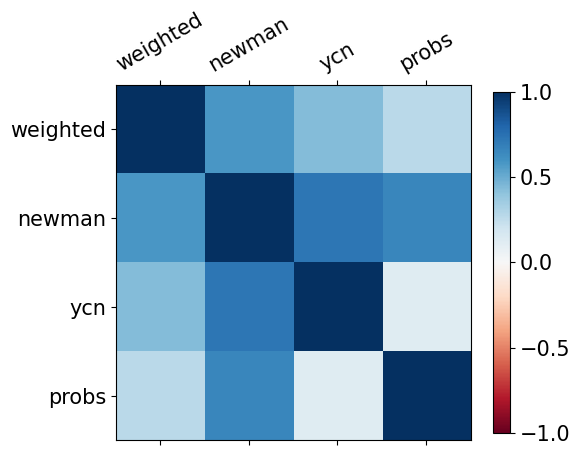

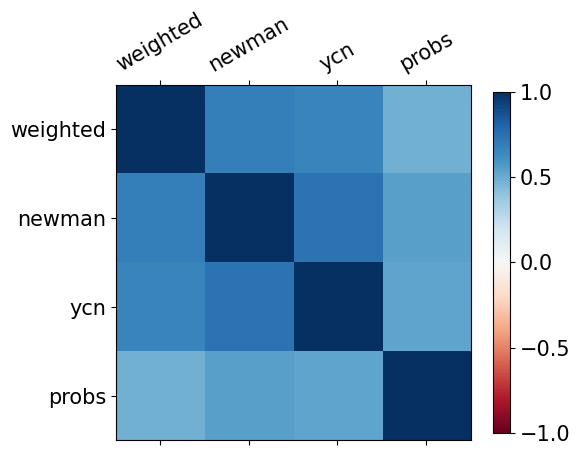

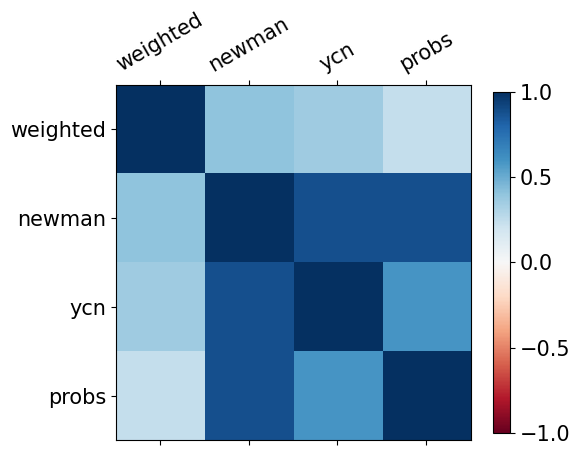

In [6]:
def fig_S11_BCD(aff):
    """
    Generates and saves a heatmap comparing different link projection methods using Spearman correlation.

    This function reads tool affinity data, applies various link projection methods, ranks the links, and compares 
    the rankings using Spearman correlation. The results are visualized as a heatmap.

    Parameters:
    aff (str): The tool affinity type to analyze. It should be one of 'nontool', 'simple', or 'complex'.

    Returns:
    None

    The function performs the following steps:
    1. Defines a list of projection methods to apply.
    2. Initializes a DataFrame to store link rankings for each method.
    3. Applies the unweighted projection method to get the initial link rankings.
    4. Iterates over the defined projection methods, applies each method, and updates the DataFrame with the rankings.
    5. Saves the DataFrame as a CSV file.
    6. Calculates the Spearman correlation between the rankings of different methods.
    7. Plots the correlation matrix as a heatmap and saves the figure as a PNG file.

    Note:
    - The function assumes the existence of CSV files for the tool affinity data.
    - The CSV files should be located in the directory specified by the variable `dat_path`.
    - The output figure is saved in the directory specified by the variable `fig_path`.

    """

    proj_methods = [weighted, newman, ycn, probs]

    df = pd.DataFrame(columns=['links']+[method.__name__ for method in proj_methods])

    link_ranking = unweighted(aff)

    df['links'] = list(link_ranking.keys())
    df['unweighted'] = list(link_ranking.values())

    true_links = list(df['links'].values)

    for method in proj_methods:
        link_ranking = method(aff)

        links = list(link_ranking.keys())

        for link in links:
            if link in true_links:
                df.loc[df['links'] == link, method.__name__] = link_ranking[link]
            else:
                try:
                    df.loc[df['links'] == (link[1], link[0]), method.__name__] = link_ranking[link]
                except:
                    print(link)

    df.to_csv(dat_path+f'{aff}_link_ranking_correlations.csv', index=False)

    # Compare all methods pairwise using Spearman correlation and plot it as a heatmap
    corr = df[[method.__name__ for method in proj_methods]].corr(method='spearman')

    fig, ax = plt.subplots(figsize=(6, 6))

    cax = ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)
    
    cbar = fig.colorbar(cax, shrink=0.65)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    
    ax.set_xticks(np.arange(len(corr.columns)))
    ax.set_yticks(np.arange(len(corr.columns)))
    
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xticks(rotation=30, ha='center')
    
    plt.tight_layout()
    plt.savefig(fig_path+f'fig_S11_BCD_{aff}.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()
    plt.close()

# Example usage
fig_S11_BCD(aff='nontool')
fig_S11_BCD(aff='simple')
fig_S11_BCD(aff='complex')